## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from scipy.stats import randint
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import joblib

## Data Loading

In [2]:
clean_attractions = pd.read_excel("data/clean_attractions.xlsx")
clean_attractions = clean_attractions.dropna()

clean_amenities = pd.read_excel("data/clean_amenities.xlsx")
clean_amenities = clean_amenities.dropna()

clean_access = pd.read_excel("data/clean_access.xlsx")
clean_access = clean_access.dropna()

clean_price = pd.read_excel("data/clean_price.xlsx")
clean_price = clean_price.dropna()

clean_no_aspect = pd.read_excel("data/clean_no_aspect.xlsx")
clean_no_aspect = clean_no_aspect.dropna()

### Encoding Label Menjadi Kode Numerik

In [3]:
label = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
    "none": 3
}

clean_attractions["label"] = clean_attractions["label"].map(label)
clean_amenities["label"] = clean_amenities["label"].map(label)
clean_access["label"] = clean_access["label"].map(label)
clean_price["label"] = clean_price["label"].map(label)
clean_no_aspect["label"] = clean_no_aspect["label"].map(label)

### Pengecekan Distribusi Label

In [4]:
distributions = {
    "attractions": clean_attractions["label"].value_counts(),
    "amenities": clean_amenities["label"].value_counts(),
    "access": clean_access["label"].value_counts(),
    "price": clean_price["label"].value_counts(),
    "no_aspect": clean_no_aspect["label"].value_counts(),
}

df_distribution = pd.DataFrame(distributions).fillna(0).astype(int)
print(df_distribution)

       attractions  amenities  access  price  no_aspect
label                                                  
0              309        227      34     27         57
1              216        154      32     18        513
2             2218        916     191    173        348
3              861       2308    3348   3387       2682


**Insight:**  
Berdasarkan grafik di atas, setiap label tidak memiliki distribusi yang merata. Review lebih banyak memiliki label positif dan review netral memiliki jumlah yang sangat sedikit. Oleh karena itu, terjadi data imbalance pada dataset dan harus ditangani agar menghasilkan model yang baik.

## Feature Extraction

In [5]:
X_attractions = clean_attractions["final_text"]
Y_attractions = clean_attractions["label"]

X_amenities = clean_amenities["final_text"]
Y_amenities = clean_amenities["label"]

X_access = clean_access["final_text"]
Y_access = clean_access["label"]

X_price = clean_price["final_text"]
Y_price = clean_price["label"]

X_no_aspect = clean_no_aspect["final_text"]
Y_no_aspect = clean_no_aspect["label"]

### TF-IDF

In [6]:
def feature_extraction(X):
    tfidf = TfidfVectorizer()
    X_tfidf = tfidf.fit_transform(X)

    return X_tfidf, tfidf

In [7]:
X_attractions_tfidf, tfidf_attractions  = feature_extraction(X_attractions)
X_amenities_tfidf, tfidf_amenities = feature_extraction(X_amenities)
X_access_tfidf, tfidf_access = feature_extraction(X_access)
X_price_tfidf, tfidf_price = feature_extraction(X_price)
X_no_aspect_tfidf, tfidf_no_aspect = feature_extraction(X_no_aspect)

### Penerapan SMOTE

In [8]:
def oversample_smote(X, Y):
    smote = SMOTE(random_state=42)
    X_smote, Y_smote = smote.fit_resample(X, Y)

    return X_smote, Y_smote

In [9]:
X_attractions_smote, Y_attractions_smote = oversample_smote(X_attractions_tfidf, Y_attractions)
X_amenities_smote, Y_amenities_smote = oversample_smote(X_amenities_tfidf, Y_amenities)
X_access_smote, Y_access_smote = oversample_smote(X_access_tfidf, Y_access)
X_price_smote, Y_price_smote = oversample_smote(X_price_tfidf, Y_price)
X_no_aspect_smote, Y_no_aspect_smote = oversample_smote(X_no_aspect_tfidf, Y_no_aspect)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hp14s\anaconda3\envs\main-ds\lib\s

### Data Splitting
Data dibagi menjadi 3 subset, yaitu 80% data training, 10% data validation, dan 10% data testing

In [10]:
# Attractions
X_attractions_train, X_attractions_temp, Y_attractions_train, Y_attractions_temp = train_test_split(
    X_attractions_smote, Y_attractions_smote, test_size=0.3, random_state=42)
X_attractions_val, X_attractions_test, Y_attractions_val, Y_attractions_test = train_test_split(
    X_attractions_temp, Y_attractions_temp, test_size=0.5, random_state=42)

# Amenities
X_amenities_train, X_amenities_temp, Y_amenities_train, Y_amenities_temp = train_test_split(
    X_amenities_smote, Y_amenities_smote, test_size=0.3, random_state=42)
X_amenities_val, X_amenities_test, Y_amenities_val, Y_amenities_test = train_test_split(
    X_amenities_temp, Y_amenities_temp, test_size=0.5, random_state=42)

# Access
X_access_train, X_access_temp, Y_access_train, Y_access_temp = train_test_split(
    X_access_smote, Y_access_smote, test_size=0.3, random_state=42)
X_access_val, X_access_test, Y_access_val, Y_access_test = train_test_split(
    X_access_temp, Y_access_temp, test_size=0.5, random_state=42)

# Price
X_price_train, X_price_temp, Y_price_train, Y_price_temp = train_test_split(
    X_price_smote, Y_price_smote, test_size=0.3, random_state=42)
X_price_val, X_price_test, Y_price_val, Y_price_test = train_test_split(
    X_price_temp, Y_price_temp, test_size=0.5, random_state=42)

# No aspect
X_no_aspect_train, X_no_aspect_temp, Y_no_aspect_train, Y_no_aspect_temp = train_test_split(
    X_no_aspect_smote, Y_no_aspect_smote, test_size=0.3, random_state=42)
X_no_aspect_val, X_no_aspect_test, Y_no_aspect_val, Y_no_aspect_test = train_test_split(
    X_no_aspect_temp, Y_no_aspect_temp, test_size=0.5, random_state=42)

### Label Encoding

In [11]:
def label_encoding(Y_train, Y_val, Y_test):
    Y_train_encoded = to_categorical(Y_train)
    Y_val_encoded   = to_categorical(Y_val)
    Y_test_encoded  = to_categorical(Y_test)

    return Y_train_encoded, Y_val_encoded, Y_test_encoded

In [12]:
Y_train_attractions_cat, Y_val_attractions_cat, Y_test_attractions_cat = label_encoding(Y_attractions_train, Y_attractions_val, Y_attractions_test)
Y_train_amenities_cat, Y_val_amenities_cat, Y_test_amenities_cat = label_encoding(Y_amenities_train, Y_amenities_val, Y_amenities_test)
Y_train_access_cat, Y_val_access_cat, Y_test_access_cat = label_encoding(Y_access_train, Y_access_val, Y_access_test)
Y_train_price_cat, Y_val_price_cat, Y_test_price_cat = label_encoding(Y_price_train, Y_price_val, Y_price_test)
Y_train_no_aspect_cat, Y_val_no_aspect_cat, Y_test_no_aspect_cat = label_encoding(Y_no_aspect_train, Y_no_aspect_val, Y_no_aspect_test)

## Modeling

### Neural Network

In [13]:
embedding_dim = 64
num_classes = 3

def neural_network(model_name, X_train):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
        f"models/nn_{model_name}.h5",
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    return model, checkpoint

In [14]:
model_attractions, checkpoint_attractions = neural_network("attractions", X_attractions_train)
model_amenities, checkpoint_amenities = neural_network("amenities", X_amenities_train)
model_access, checkpoint_access = neural_network("access", X_access_train)
model_price, checkpoint_price = neural_network("price", X_price_train)
model_no_aspect, checkpoint_no_aspect = neural_network("no_aspect", X_no_aspect_train)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Fungsi untuk Plot Learning Curve

In [15]:
def plot_learning_curve(hist):
    history = hist.history

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Random Forest

In [16]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

def random_forest(X_train, Y_train):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, Y_train)

    return rf

In [17]:
rf_attractions = random_forest(X_attractions_train, Y_train_attractions_cat)
rf_amenities = random_forest(X_amenities_train, Y_train_amenities_cat)
rf_access = random_forest(X_access_train, Y_train_access_cat)
rf_price = random_forest(X_price_train, Y_train_price_cat)
rf_no_aspect = random_forest(X_no_aspect_train, Y_train_no_aspect_cat)

### Attractions

In [18]:
hist_attractions = model_attractions.fit(
    X_attractions_train, Y_train_attractions_cat,
    epochs=20,
    validation_data=(X_attractions_val, Y_val_attractions_cat),
    callbacks=[checkpoint_attractions]
)

Epoch 1/20
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5674 - loss: 1.0786
Epoch 1: val_accuracy improved from -inf to 0.90158, saving model to models/nn_attractions.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5699 - loss: 1.0732 - val_accuracy: 0.9016 - val_loss: 0.2697
Epoch 2/20
184/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9467 - loss: 0.1566
Epoch 2: val_accuracy improved from 0.90158 to 0.93914, saving model to models/nn_attractions.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9467 - loss: 0.1563 - val_accuracy: 0.9391 - val_loss: 0.1785
Epoch 3/20
192/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9782 - loss: 0.0663
Epoch 3: val_accuracy did not improve from 0.93914
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9782 - loss: 0.0662 - val_accuracy: 0.9376 - val_loss: 0.1826
Epoch 4/20
187/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0382
Epoch 4: val_accuracy did not improve from 0.93914
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9872 - loss: 0.0382 - val_accuracy: 0.9294 - val_loss: 0.2100
Epoch 5/20
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9921 - loss: 0.0235
Epoch 5: val_accuracy did not improve from 0.93914
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9921 - loss: 0.0235 - val_accuracy: 0.9346 - val_loss: 0.2253
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0205
Epoch 6: val_accuracy did not impro

#### Learning Curve

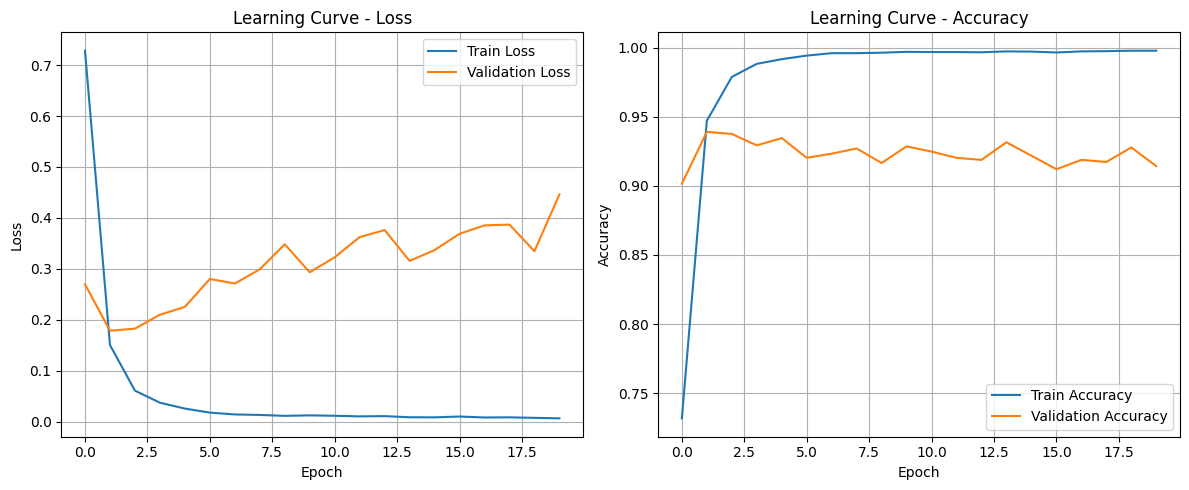

In [19]:
plot_learning_curve(hist_attractions)

### Amenities

In [20]:
hist_amenities = model_amenities.fit(
    X_amenities_train, Y_train_amenities_cat,
    epochs=20,
    validation_data=(X_amenities_val, Y_val_amenities_cat),
    callbacks=[checkpoint_amenities]
)

Epoch 1/20
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 0.9862
Epoch 1: val_accuracy improved from -inf to 0.93285, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6732 - loss: 0.9823 - val_accuracy: 0.9329 - val_loss: 0.1933
Epoch 2/20
194/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9792 - loss: 0.0774
Epoch 2: val_accuracy improved from 0.93285 to 0.94801, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9791 - loss: 0.0771 - val_accuracy: 0.9480 - val_loss: 0.1403
Epoch 3/20
193/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9926 - loss: 0.0278
Epoch 3: val_accuracy did not improve from 0.94801
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9927 - loss: 0.0276 - val_accuracy: 0.9458 - val_loss: 0.1617
Epoch 4/20
193/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0074
Epoch 4: val_accuracy improved from 0.94801 to 0.95596, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9985 - loss: 0.0076 - val_accuracy: 0.9560 - val_loss: 0.1533
Epoch 5/20
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0107
Epoch 5: val_accuracy did not improve from 0.95596
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9975 - loss: 0.0107 - val_accuracy: 0.9531 - val_loss: 0.1751
Epoch 6/20
199/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0046
Epoch 6: val_accuracy did not improve from 0.95596
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0046 - val_accuracy: 0.9458 - val_loss: 0.1987
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0054
Epoch 7: val_accuracy did not improve from 0.95596
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9458 - val_loss: 0.2334
Epoch 8/20
196/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0022
Epoch 8: val_accuracy did not impro

#### Learning Curve

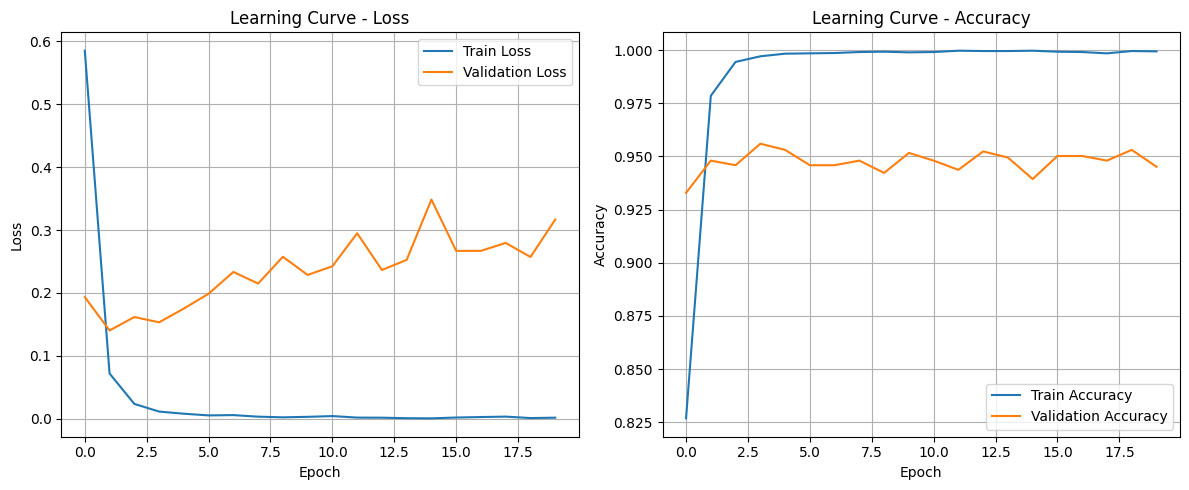

In [21]:
plot_learning_curve(hist_amenities)

### Access

In [22]:
hist_access = model_access.fit(
    X_access_train, Y_train_access_cat,
    epochs=20,
    validation_data=(X_access_val, Y_val_access_cat),
    callbacks=[checkpoint_access]
)

Epoch 1/20
286/293 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8374 - loss: 0.6196
Epoch 1: val_accuracy improved from -inf to 0.99602, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8404 - loss: 0.6093 - val_accuracy: 0.9960 - val_loss: 0.0127
Epoch 2/20
290/293 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9985 - loss: 0.0062
Epoch 2: val_accuracy improved from 0.99602 to 0.99751, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9975 - val_loss: 0.0067
Epoch 3/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9456e-04
Epoch 3: val_accuracy did not improve from 0.99751
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 7.9781e-04 - val_accuracy: 0.9975 - val_loss: 0.0086
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1368e-04
Epoch 4: val_accuracy did not improve from 0.99751
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 6.1290e-04 - val_accuracy: 0.9970 - val_loss: 0.0087
Epoch 5/20
290/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2847e-04
Epoch 5: val_accuracy improved from 0.99751 to 0.99801, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 1.2844e-04 - val_accuracy: 0.9980 - val_loss: 0.0070
Epoch 6/20
287/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.3476e-05
Epoch 6: val_accuracy did not improve from 0.99801
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 8.3499e-05 - val_accuracy: 0.9980 - val_loss: 0.0074
Epoch 7/20
288/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.2797e-05
Epoch 7: val_accuracy did not improve from 0.99801
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 6.2726e-05 - val_accuracy: 0.9980 - val_loss: 0.0080
Epoch 8/20
289/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.6041e-05
Epoch 8: val_accuracy did not improve from 0.99801
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 4.5985e-05 - val_accuracy: 0.9980 - val_loss: 0.0082
Epoch 9/20
283/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4874e-05
Epo

#### Learning Curve

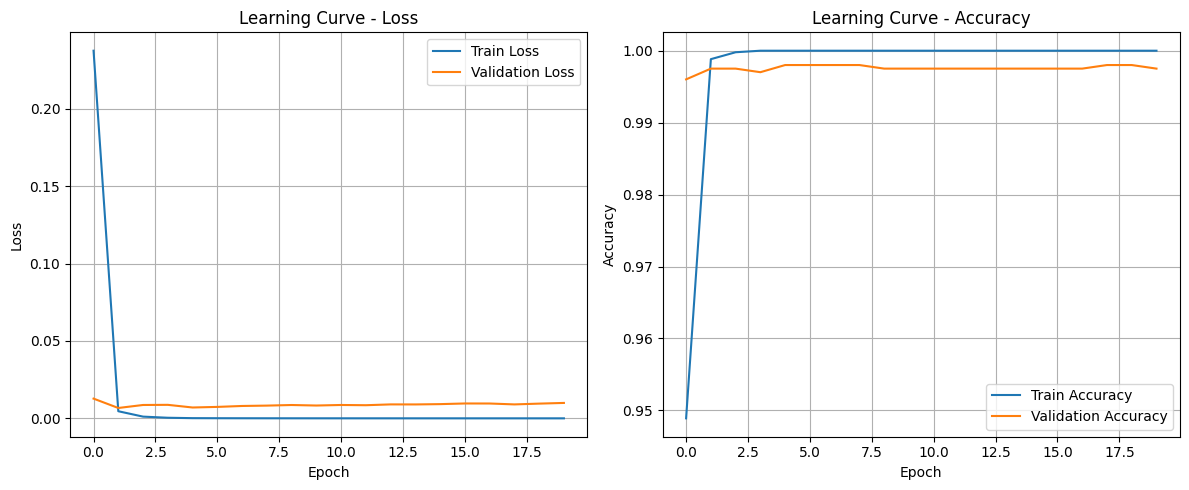

In [23]:
plot_learning_curve(hist_access)

### Price

In [24]:
hist_price = model_price.fit(
    X_price_train, Y_train_price_cat,
    epochs=20,
    validation_data=(X_price_val, Y_val_price_cat),
    callbacks=[checkpoint_price]
)

Epoch 1/20
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8499 - loss: 0.5889
Epoch 1: val_accuracy improved from -inf to 0.99754, saving model to models/nn_price.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8510 - loss: 0.5851 - val_accuracy: 0.9975 - val_loss: 0.0053
Epoch 2/20
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0024
Epoch 2: val_accuracy improved from 0.99754 to 0.99852, saving model to models/nn_price.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 3/20
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.9846e-04
Epoch 3: val_accuracy did not improve from 0.99852
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 1.0000 - loss: 3.1037e-04 - val_accuracy: 0.9985 - val_loss: 0.0035
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.4627e-04
Epoch 4: val_accuracy did not improve from 0.99852
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 1.4618e-04 - val_accuracy: 0.9985 - val_loss: 0.0043
Epoch 5/20
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.4684e-05
Epoch 5: val_accuracy did not improve from 0.99852
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 1.0000 - loss: 7.4511e-05 - val_accuracy: 0.9985 - val_loss: 0.0044
Epoch 6/20
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2788e-05
Epo

297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 2.9849e-05 - val_accuracy: 0.9990 - val_loss: 0.0043
Epoch 8/20
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1481e-05
Epoch 8: val_accuracy did not improve from 0.99902
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 1.0000 - loss: 2.1422e-05 - val_accuracy: 0.9990 - val_loss: 0.0043
Epoch 9/20
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7075e-05
Epoch 9: val_accuracy did not improve from 0.99902
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 1.7030e-05 - val_accuracy: 0.9990 - val_loss: 0.0044
Epoch 10/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.1592e-05
Epoch 10: val_accuracy did not improve from 0.99902
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 1.1592e-05 - val_accuracy: 0.9990 - val_loss: 0.0044
Epoch 11/20
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.8275e-06

#### Learning Curve

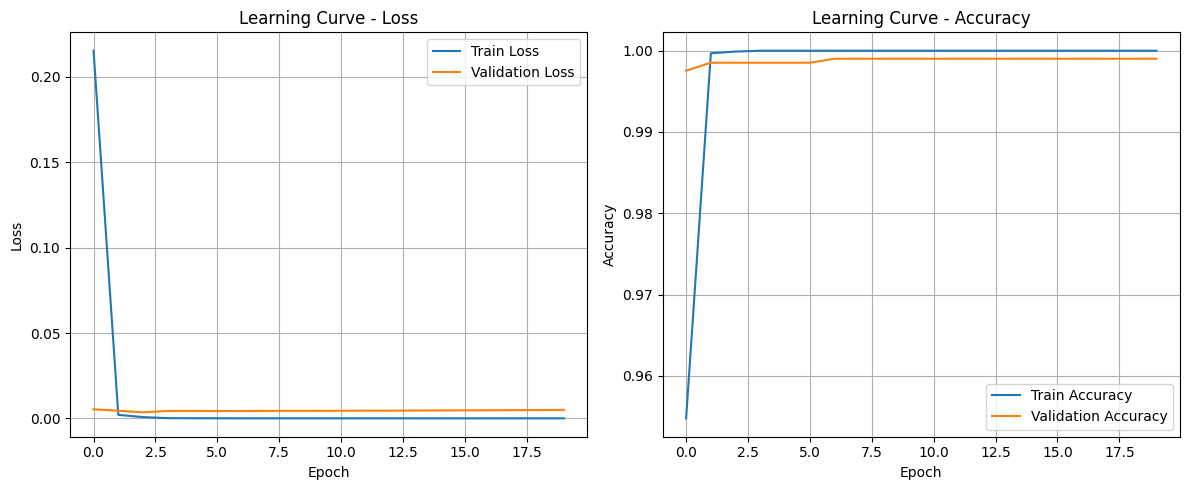

In [25]:
plot_learning_curve(hist_price)

### No Aspect

In [26]:
hist_no_aspect = model_no_aspect.fit(
    X_no_aspect_train, Y_train_no_aspect_cat,
    epochs=20,
    validation_data=(X_no_aspect_val, Y_val_no_aspect_cat),
    callbacks=[checkpoint_no_aspect]
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6379 - loss: 0.9486
Epoch 1: val_accuracy improved from -inf to 0.94717, saving model to models/nn_no_aspect.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6386 - loss: 0.9470 - val_accuracy: 0.9472 - val_loss: 0.1633
Epoch 2/20
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9727 - loss: 0.0905
Epoch 2: val_accuracy improved from 0.94717 to 0.95587, saving model to models/nn_no_aspect.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9727 - loss: 0.0905 - val_accuracy: 0.9559 - val_loss: 0.1401
Epoch 3/20
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9879 - loss: 0.0421
Epoch 3: val_accuracy did not improve from 0.95587
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9879 - loss: 0.0421 - val_accuracy: 0.9546 - val_loss: 0.1537
Epoch 4/20
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9924 - loss: 0.0267
Epoch 4: val_accuracy did not improve from 0.95587
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9924 - loss: 0.0267 - val_accuracy: 0.9472 - val_loss: 0.1893
Epoch 5/20
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9949 - loss: 0.0198
Epoch 5: val_accuracy did not improve from 0.95587
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9949 - loss: 0.0198 - val_accuracy: 0.9484 - val_loss: 0.1962
Epoch 6/20
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9936 - loss: 0.0210
Epoch 6: val_accuracy did not

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9961 - loss: 0.0111 - val_accuracy: 0.9571 - val_loss: 0.1770
Epoch 10/20
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0179
Epoch 10: val_accuracy did not improve from 0.95712
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9945 - loss: 0.0178 - val_accuracy: 0.9391 - val_loss: 0.2866
Epoch 11/20
226/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0091
Epoch 11: val_accuracy did not improve from 0.95712
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9977 - loss: 0.0093 - val_accuracy: 0.9354 - val_loss: 0.2993
Epoch 12/20
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - loss: 0.0079
Epoch 12: val_accuracy did not improve from 0.95712
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9979 - loss: 0.0080 - val_accuracy: 0.9553 - val_loss: 0.2077
Epoch 13/20
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9954 - loss: 0.0129
Epoch 13: val_accuracy did n

#### Learning Curve

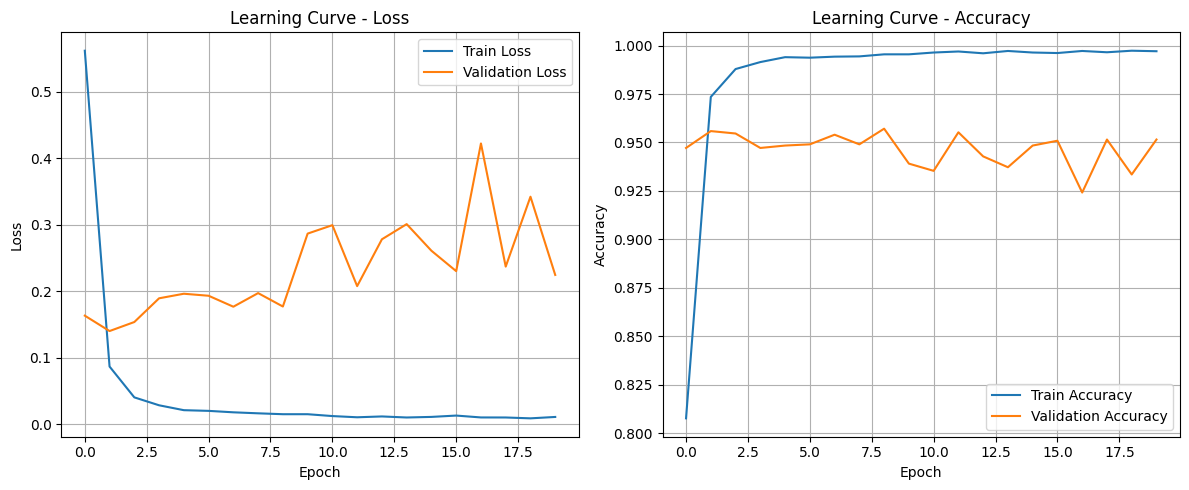

In [27]:
plot_learning_curve(hist_no_aspect)

## Evaluasi

In [28]:
def evaluate_model(model_nn, model_rf, X_train, Y_train, X_test, Y_test):
    train_loss_nn, train_accuracy_nn = model_nn.evaluate(X_train, Y_train, verbose=0)
    test_loss_nn, test_accuracy_nn = model_nn.evaluate(X_test, Y_test, verbose=0)

    Y_train_pred_rf = model_rf.predict(X_train)
    Y_test_pred_rf = model_rf.predict(X_test)
    train_accuracy_rf = accuracy_score(Y_train, Y_train_pred_rf)
    test_accuracy_rf = accuracy_score(Y_test, Y_test_pred_rf)

    return train_accuracy_nn, test_accuracy_nn, train_accuracy_rf, test_accuracy_rf

### Attractions

In [29]:
train_accuracy_nn_attractions, test_accuracy_nn_attractions, train_accuracy_rf_attractions, test_accuracy_rf_attractions = evaluate_model(
    model_attractions, rf_attractions, X_attractions_train, Y_train_attractions_cat, X_attractions_test, Y_test_attractions_cat)

train_accuracy_nn_amenities, test_accuracy_nn_amenities, train_accuracy_rf_amenities, test_accuracy_rf_amenities = evaluate_model(
    model_amenities, rf_amenities, X_amenities_train, Y_train_amenities_cat, X_amenities_test, Y_test_amenities_cat)

train_accuracy_nn_access, test_accuracy_nn_access, train_accuracy_rf_access, test_accuracy_rf_access = evaluate_model(
    model_access, rf_access, X_access_train, Y_train_access_cat, X_access_test, Y_test_access_cat)

train_accuracy_nn_price, test_accuracy_nn_price, train_accuracy_rf_price, test_accuracy_rf_price = evaluate_model(
    model_price, rf_price, X_price_train, Y_train_price_cat, X_price_test, Y_test_price_cat)

train_accuracy_nn_no_aspect, test_accuracy_nn_no_aspect, train_accuracy_rf_no_aspect, test_accuracy_rf_no_aspect = evaluate_model(  
    model_no_aspect, rf_no_aspect, X_no_aspect_train, Y_train_no_aspect_cat, X_no_aspect_test, Y_test_no_aspect_cat)

In [30]:
rows = [
    {
        "Aspect": "attractions",
        "Train Accuracy (NN)": round(train_accuracy_nn_attractions, 4),
        "Test Accuracy (NN)": round(test_accuracy_nn_attractions, 4),
        "Train Accuracy (RF)": round(train_accuracy_rf_attractions, 4),
        "Test Accuracy (RF)": round(test_accuracy_rf_attractions, 4)
    },
    {
        "Aspect": "amenities",
        "Train Accuracy (NN)": round(train_accuracy_nn_amenities, 4),
        "Test Accuracy (NN)": round(test_accuracy_nn_amenities, 4),
        "Train Accuracy (RF)": round(train_accuracy_rf_amenities, 4),
        "Test Accuracy (RF)": round(test_accuracy_rf_amenities, 4)
    },
    {
        "Aspect": "access",
        "Train Accuracy (NN)": round(train_accuracy_nn_access, 4),
        "Test Accuracy (NN)": round(test_accuracy_nn_access, 4),
        "Train Accuracy (RF)": round(train_accuracy_rf_access, 4),
        "Test Accuracy (RF)": round(test_accuracy_rf_access, 4)
    },
    {
        "Aspect": "price",
        "Train Accuracy (NN)": round(train_accuracy_nn_price, 4),
        "Test Accuracy (NN)": round(test_accuracy_nn_price, 4),
        "Train Accuracy (RF)": round(train_accuracy_rf_price, 4),
        "Test Accuracy (RF)": round(test_accuracy_rf_price, 4)
    },
    {
        "Aspect": "no_aspect",
        "Train Accuracy (NN)": round(train_accuracy_nn_no_aspect, 4),
        "Test Accuracy (NN)": round(test_accuracy_nn_no_aspect, 4),
        "Train Accuracy (RF)": round(train_accuracy_rf_no_aspect, 4),
        "Test Accuracy (RF)": round(test_accuracy_rf_no_aspect, 4)
    }
]

# Buat DataFrame
result_df = pd.DataFrame(rows)
result_df.to_excel("data/accuracy_result.xlsx", index=False)

# Tampilkan hasil
print(result_df)

        Aspect  Train Accuracy (NN)  Test Accuracy (NN)  Train Accuracy (RF)  \
0  attractions               0.9984              0.9106               0.9987   
1    amenities               0.9997              0.9430               0.9998   
2       access               1.0000              0.9980               1.0000   
3        price               1.0000              0.9995               1.0000   
4    no_aspect               0.9967              0.9491               0.9987   

   Test Accuracy (RF)  
0              0.8655  
1              0.9061  
2              0.9915  
3              0.9941  
4              0.9143  


## Simpan Model

### TF-IDF

In [31]:
joblib.dump(tfidf_attractions, "models/tfidf_attractions.pkl")
joblib.dump(tfidf_amenities, "models/tfidf_amenities.pkl")
joblib.dump(tfidf_access, "models/tfidf_access.pkl")
joblib.dump(tfidf_price, "models/tfidf_price.pkl")
joblib.dump(tfidf_no_aspect, "models/tfidf_no_aspect.pkl")

['models/tfidf_no_aspect.pkl']

### Random Forest

In [32]:
joblib.dump(rf_attractions, "models/rf_attractions.joblib")
joblib.dump(rf_amenities, "models/rf_amenities.joblib") 
joblib.dump(rf_access, "models/rf_access.joblib")
joblib.dump(rf_price, "models/rf_price.joblib")
joblib.dump(rf_no_aspect, "models/rf_no_aspect.joblib")

['models/rf_no_aspect.joblib']